In [1]:
# If RdKit is not install uncomment the command below to install
!pip install rdkit-pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 33.6 MB/s eta 0:00:00


In [2]:
# Import Necessary Libraries
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdDistGeom
from rdkit.Chem import rdMolAlign
from rdkit.Chem.Draw import IPythonConsole
print(rdkit.__version__)

2022.09.5


In [ ]:
"""
We will use the newer version of Distance Geomentry (DG) module called ETKDG.
The conformer generator ETKDG is a stochastic search method that utilizes distance 
geometry together with knowledge derived from experimental crystal structures.
It has been shown to generate good conformers for acyclic, flexible molecules.
This work builds on ETKDG to improve conformer generation of molecules containing
small or large aliphatic (i.e., non-aromatic) rings.
Reference:
Improving Conformer Generation for Small Rings and Macrocycles Based on Distance Geometry and Experimental Torsional-Angle Preferences
https://pubs.acs.org/doi/10.1021/acs.jcim.0c00025

"""

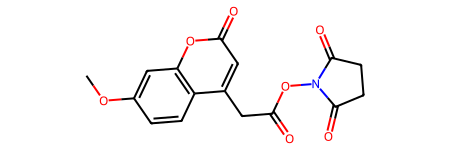

In [59]:
# Generating RDKit Molecule From Smiles
# We are using "-Methoxycoumarin-4-acetic Acid N-Succinimidyl Ester" as an example
m_noH = Chem.MolFromSmiles('COC1=CC2=C(C=C1)C(=CC(=O)O2)CC(=O)ON3C(=O)CCC3=O')
m_noH

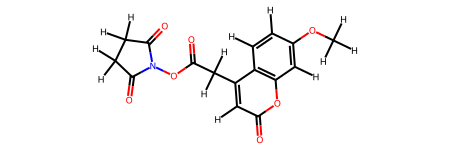

In [60]:
# Adding Hydrogens to the Molecule for visual purpose only
# Later we remove them
m_H = Chem.AddHs(m_noH)
m_H

In [61]:
# Initialize the ETKDG class
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xd06f00d
ps.numThreads = 10
cids = rdDistGeom.EmbedMultipleConfs(m_H,300,ps)
len(cids)

300

In [62]:
# Lets get rid of the hydrogen, they no longer provide useful information
m_3d = Chem.RemoveHs(m_H)

In [63]:
# Direct vs Best Alignment
maxd = -100
for j in range(0,5):
    for i in range(j,len(cids)):
        d1 = rdMolAlign.AlignMol(m_3d,m_3d,prbCid=cids[i],refCid=cids[j])
        d2 = rdMolAlign.GetBestRMS(m_3d,m_3d,prbId=cids[i],refId=cids[j])
        delt = d1-d2
        if delt<-1e-5:
            print(f'ooops, {i}, {delt}')
        if delt>maxd:
            maxd = delt
            maxi = i
            maxj = j
d1 = rdMolAlign.AlignMol(m_3d,m_3d,prbCid=cids[maxi],refCid=cids[maxj])
d2 = rdMolAlign.GetBestRMS(m_3d,m_3d,prbId=cids[maxi],refId=cids[maxj])
print(maxi,maxd,d1,d2)

45 1.3894486408458309 1.5715078076848763 0.18205916683900755


In [64]:
#!pip install py3Dmol

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
import py3Dmol
def drawit(m_noH, cids=[-1], p=None, removeHs=True,
           colors=('cyanCarbon','redCarbon','blueCarbon','magentaCarbon','whiteCarbon','purpleCarbon')):
        if removeHs:
            m = Chem.RemoveHs(m_noH)
        if p is None:
            p = py3Dmol.view(width=400, height=400)
        p.removeAllModels()
        for i,cid in enumerate(cids):
            IPythonConsole.addMolToView(m_noH,p,confId=cid)
        for i,cid in enumerate(cids):
            p.setStyle({'model':i,},
                            {'stick':{'colorscheme':colors[i%len(colors)]}})
        p.zoomTo()
        return p.show()

In [66]:
d1 = rdMolAlign.AlignMol(m_3d,m_3d,prbCid=cids[maxi],refCid=cids[maxj])
drawit(m_3d,[cids[maxj],cids[maxi]])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [67]:
d2 = rdMolAlign.GetBestRMS(m_3d,m_3d,prbId=cids[maxi],refId=cids[maxj])
drawit(m_3d,[cids[maxj],cids[maxi]])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [68]:
dists = []
for i in range(len(cids)):
    for j in range(i):
        dists.append(rdMolAlign.GetBestRMS(m_3d,m_3d,i,j))

In [69]:
from rdkit.ML.Cluster import Butina
clusts = Butina.ClusterData(dists, len(cids), 1.5, isDistData=True, reordering=True)
len(clusts)

2

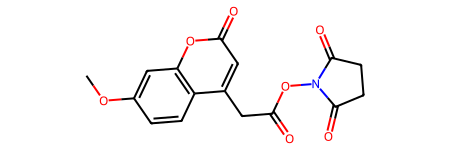

In [70]:
m_noH

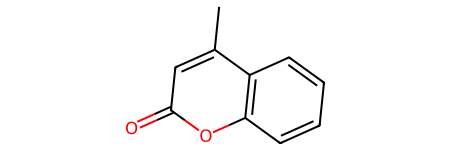

In [71]:
core = Chem.MolFromSmiles('C1=CC2=C(C=C1)C(=CC(=O)O2)C')
core

In [72]:
rdMolAlign.AlignMolConformers(m_3d,atomIds = m_3d.GetSubstructMatch(core))

In [75]:
centroids = [x[0] for x in clusts]
drawit(m_3d,centroids[:5])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol